# Week 2. Deep Neural Networks for Time Series

# Lab 1: Preparing Time Series Features and Labels

In [1]:
import tensorflow as tf

# generate the data
print("\nThe data:")
dataset = tf.data.Dataset.range(10)

for data in dataset:
  print(data.numpy())

# windowing the data
print("\nWindowed data:")
dataset = dataset.window(size=5, shift=1, drop_remainder=True)

for data in dataset:
  print([item.numpy() for item in data]) # can't access directly to the data

# flatten the windows
print("\nFlatten data:")
dataset = dataset.flat_map(lambda window: window.batch(5))

for data in dataset:
  print(data.numpy())

# split the data into fetarues and labels
print("\nSplitted data:")
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

for x, y in dataset:
  print(f'x: {x.numpy()}')
  print(f'y: {y.numpy()}')

# shuffle the data
print("\nShuffled data:")
dataset = dataset.shuffle(buffer_size=10)

for x, y in dataset:
  print(f'x: {x.numpy()}')
  print(f'y: {y.numpy()}')

# create batches for training
print("\nBatched data:")
dataset = dataset.batch(batch_size=2).prefetch(1)

for x, y in dataset:
  print(f'x: {x.numpy()}')
  print(f'y: {y.numpy()}')


The data:
0
1
2
3
4
5
6
7
8
9

Windowed data:
[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]

Flatten data:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]

Splitted data:
x: [0 1 2 3]
y: 4
x: [1 2 3 4]
y: 5
x: [2 3 4 5]
y: 6
x: [3 4 5 6]
y: 7
x: [4 5 6 7]
y: 8
x: [5 6 7 8]
y: 9

Shuffled data:
x: [5 6 7 8]
y: 9
x: [4 5 6 7]
y: 8
x: [0 1 2 3]
y: 4
x: [1 2 3 4]
y: 5
x: [3 4 5 6]
y: 7
x: [2 3 4 5]
y: 6

Batched data:
x: [[5 6 7 8]
 [0 1 2 3]]
y: [9 4]
x: [[2 3 4 5]
 [3 4 5 6]]
y: [6 7]
x: [[1 2 3 4]
 [4 5 6 7]]
y: [5 8]


# Lab 2: Training a Single Layer Neural Network with Time Series Data

Now that you've seen statistical methods in the previous week, you will now shift to using neural networks to build your prediction models. You will start with a simple network in this notebook and move on to more complex architectures in the next weeks. By the end of this lab, you will be able to:

* build a single layer network and train it using the same synthetic data you used in the previous lab
* prepare time series data for training and evaluation
* measure the performance of your model against a validation set

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Utilities

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

### Generate the synthetic data

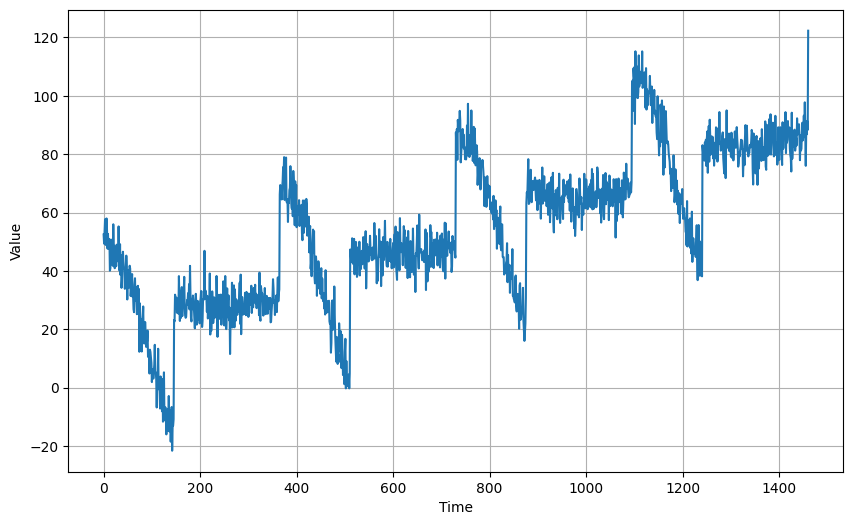

In [4]:
time = np.arange(4 * 365 + 1, dtype="float32")

baseline = 10
slope = 0.05
amplitude = 40
period = 365
noise_level = 5
seed = 42

series = baseline + seasonality(time, period, amplitude) + trend(time, slope)

series += noise(time, noise_level, seed)

plot_series(time, series)

### Split the data

In [5]:
TIME_SPLIT = 1000

time_train = time[:TIME_SPLIT]
series_train = series[:TIME_SPLIT]

time_valid = time[TIME_SPLIT:]
series_valid = series[TIME_SPLIT:]

## Generate features and labels

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):

  # get the data
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # cerate window (+1 for label)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

  # flat the data
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # separate feature and label
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # shuffle the data
  dataset = dataset.shuffle(shuffle_buffer_size)

  # create batche data
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [7]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)


## Build and Compile the model

In [8]:
# input shape equals the number of fetaures /X value to train
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.Sequential([l0])

print('Weights of layer before training: \n{}\n'.format(l0.get_weights()))
model.summary()

Weights of layer before training: 
[array([[ 0.48972005],
       [ 0.20531785],
       [-0.51004875],
       [ 0.42139745],
       [ 0.36893612],
       [ 0.3768922 ],
       [-0.15736061],
       [ 0.26060647],
       [ 0.29925275],
       [-0.16311094],
       [ 0.23012227],
       [ 0.33016133],
       [-0.5098538 ],
       [ 0.14553034],
       [ 0.05381286],
       [-0.33713436],
       [ 0.45772922],
       [-0.42922089],
       [ 0.2524324 ],
       [ 0.4609874 ]], dtype=float32), array([0.], dtype=float32)]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from keras.src.optimizers import SGD
model.compile(loss="mse", optimizer=SGD(learning_rate=1e-6, momentum=0.9))

## Train the model

In [ ]:
model.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 291.8763
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 184.2880
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 138.3589
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 115.4571
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 100.2661
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 92.0950
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 86.8544
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 82.4575
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 81.1261
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 77.2239
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 75.2281
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 75.0785
Epoch 13/100
31/31 [

In [ ]:
print('Weights of layer after training: \n{}'.format(l0.get_weights()))

Weights of layer after training: 
[array([[-0.03355766],
       [-0.03713738],
       [ 0.0453875 ],
       [ 0.03612288],
       [ 0.05058607],
       [-0.05403021],
       [-0.03070588],
       [ 0.06028835],
       [-0.06512964],
       [ 0.02822123],
       [ 0.01610965],
       [-0.03871573],
       [ 0.0223358 ],
       [ 0.09613919],
       [-0.06561845],
       [ 0.05838356],
       [-0.00100455],
       [ 0.20450312],
       [ 0.3021866 ],
       [ 0.42174858]], dtype=float32), array([0.01253232], dtype=float32)]


## Model prediction

In [ ]:
prediction = model.predict(series[0:20][np.newaxis])
print(prediction)

1/1 [==============================] - 0s 36ms/step
[[45.938656]]


In [ ]:
forecasts = []

for time in range(len(series) - window_size):
  forecast = model.predict(series[time : time+window_size][np.newaxis])
  forecasts.append(forecast)

predicted_series = forecasts[TIME_SPLIT-window_size:]

1/1 [==============================] - 0s 20ms/step


Shape after comverting to numpy array (461, 1, 1)
Shape after squeezing the numpy array (461,)


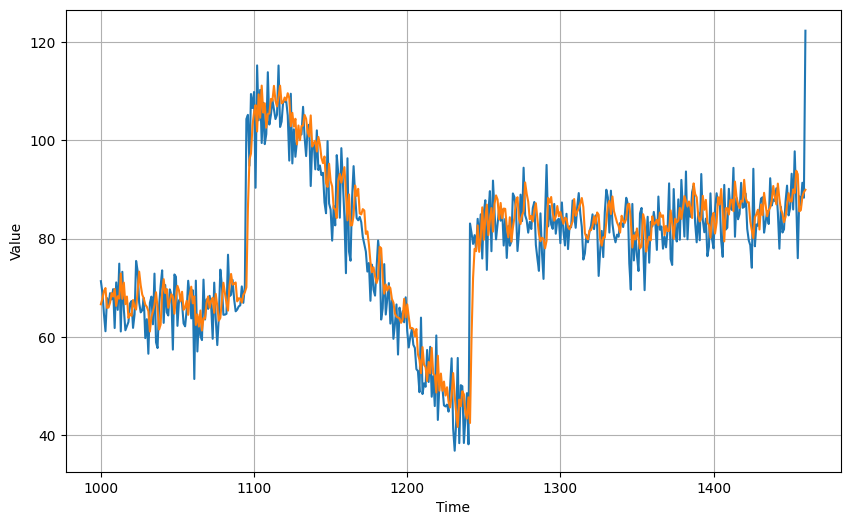

In [ ]:
print(f'Shape after comverting to numpy array {np.array(predicted_series).shape}')
print(f'Shape after squeezing the numpy array {np.squeeze(predicted_series).shape}')

results = np.squeeze(predicted_series)
plot_series(time_valid, (series_valid, results))

In [ ]:
print(f'mse: {tf.keras.metrics.mean_squared_error(series_valid, results)}')
print(f'mae: {tf.keras.metrics.mean_absolute_error(series_valid, results)}')

mse: 45.9031867980957
mae: 5.119570732116699


To sum up, time series prediction uses time  and series. And to make prediction, we create sequence models and process the series part into features and labels: predicting the next values after knowing the predefined values before

# Lab 3: Training a Deep Neural Network
rebuild the network before with deeper architecture neural network

##  Deeper neural Network

In [51]:
model_baseline = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)])

model_baseline.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 10)                210       
                                                                 
 dense_24 (Dense)            (None, 10)                110       
                                                                 
 dense_25 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
model_baseline.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

model_baseline.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 178.7806
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 94.6270
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 79.1828
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 69.2682
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 64.0668
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 62.2413
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 62.4471
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 60.5144
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 60.0430
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 57.5191
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 55.5368
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 55.6227
Epoch 13/100
31/31 [====

In [53]:
forecast = []

forecast_series = series[TIME_SPLIT-window_size:]

for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time: time+window_size][np.newaxis]))



1/1 [==============================] - 0s 35ms/step


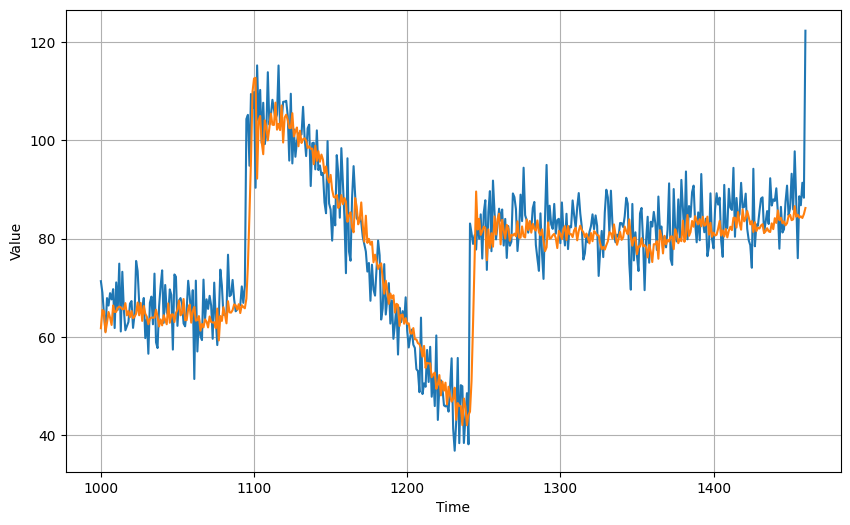

In [54]:
results = np.array(forecast).squeeze()

plot_series(time_valid, (series_valid, results))

In [55]:
print(tf.keras.metrics.mean_squared_error(series_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(series_valid, results).numpy())

47.30393
4.958025


## Choose the best learning rate
use lr_scheduler on callbacks to get the best learning rate optimizer

In [56]:
model_tune = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)])

model_tune.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 10)                210       
                                                                 
 dense_27 (Dense)            (None, 10)                110       
                                                                 
 dense_28 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch/20)
)


In [58]:
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_tune.compile(loss="mse", optimizer=optimizer)

In [59]:
history = model_tune.fit(dataset, epochs=100, callbacks=lr_schedule)

Epoch 1/100
31/31 [==============================] - 1s 5ms/step - loss: 232.0434 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 230.5107 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 228.8111 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 226.9003 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 224.7717 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 222.5555 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 220.0838 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 217.6238 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 214.8117 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 211.9899 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 300.0)

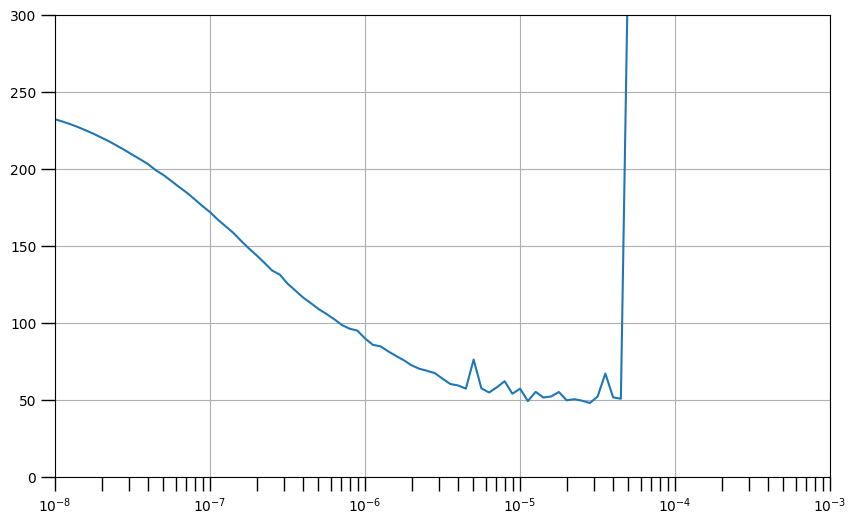

In [60]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

In [66]:
model_tune = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)])


model_tune.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9))

history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 629.2824
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 101.7329
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 71.0648
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 64.6732
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 58.7979
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 56.2296
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 55.5471
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 56.1680
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 53.6396
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 52.0889
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 51.1303
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 51.3734
Epoch 13/100
31/31 [===

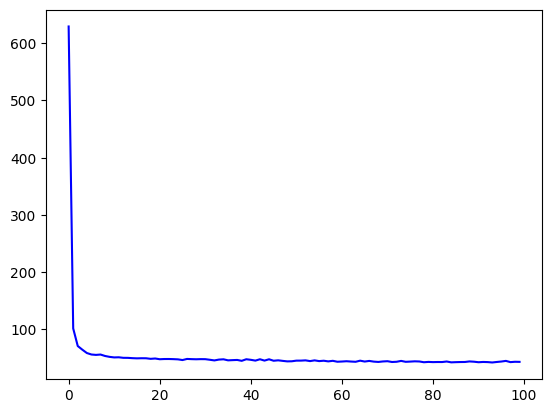

In [67]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()


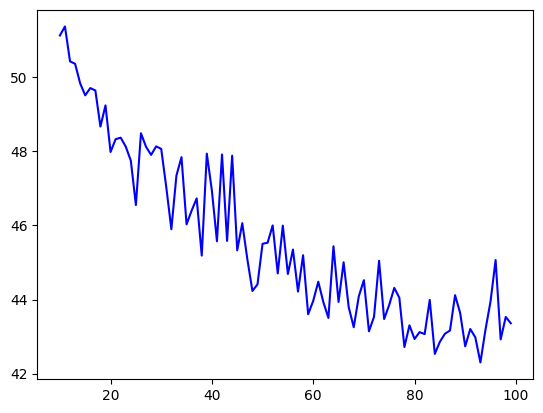

In [68]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

1/1 [==============================] - 0s 44ms/step


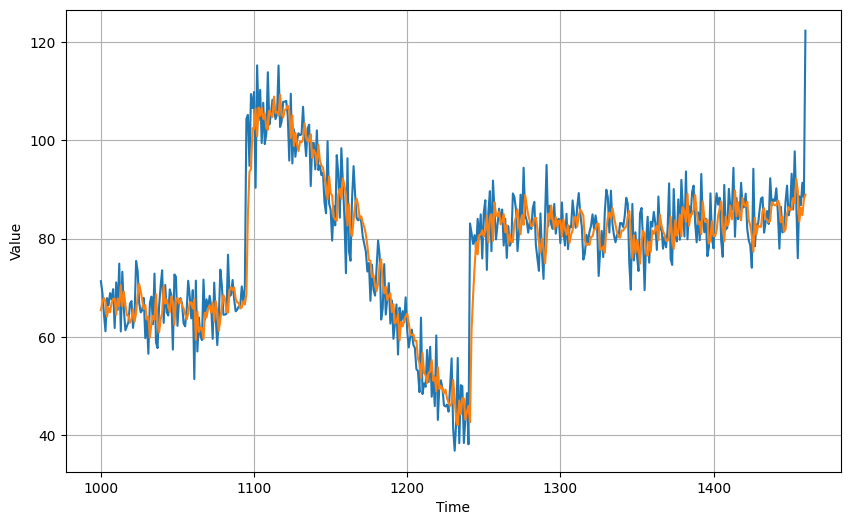

In [71]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[TIME_SPLIT - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (series_valid, results))

In [73]:
print(tf.keras.metrics.mean_squared_error(series_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(series_valid, results).numpy())

44.039543
4.8961444
